In [151]:
# Setup
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sys, os
#os.chdir('data')
from colorsetup import colors, palette
sns.set_palette(palette)
import warnings
warnings.simplefilter(action='ignore')
import fbprophet
import pmdarima as pm

In [152]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [156]:
covid = pd.read_csv('./COVID-19 di Indonesia @kawalcovid19 - Statistik Harian.csv')
covid.head()

,Unnamed: 0,Kasus harian,Kasus Impor,Kasus Lokal,Total kasus,Kasus aktif,% kasus aktif,Sembuh\n(baru),Sembuh,Tingkat kesembuhan (seluruh kasus),...,Positif DKI,Unnamed: 76,Pos Rate DKI,Pos Rate DKI - 7 harian,NON DKI,Positif Non DKI,Unnamed: 81,Pos Rate Non DKI,Pos Rate Non DKI - 7 harian,CFR
0,3/2/2020,2,0.0,2.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3/3/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3/4/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3/5/2020,0,0.0,0.0,2,2,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3/6/2020,2,0.0,2.0,4,4,100.00%,0,0,0.00%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
covid.columns


Index(['Unnamed: 0', 'Kasus harian', 'Kasus Impor', 'Kasus Lokal',
       'Total kasus', 'Kasus aktif', '% kasus aktif', 'Sembuh\n(baru)',
       'Sembuh', 'Tingkat kesembuhan (seluruh kasus)',
       'Tingkat kesembuhan (closed cases)', 'Meninggal\n(baru)',
       'Meninggal\nDunia', 'Tingkat kematian (seluruh kasus)',
       'Tingkat kematian (closed cases)', 'PDP', 'ODP', 'Suspek aktif',
       'Jumlah spesimen diperiksa (dari 1 April)', 'Jumlah orang diperiksa',
       'Negatif', 'Positif \n(=C)', 'Dalam Proses', 'Spesimen',
       'Spesimen (PCR-TCM)', 'Spesimen (Antigen)', 'Orang yang dites',
       'Orang yang dites (PCR-TCM)', 'Orang yang dites (Antigen)',
       'Vaksinasi (ineligible)', 'Jumlah test/juta penduduk', 'Test/Positif',
       'Jumlah org yg dites / positif', 'Jumlah Test/Positif harian',
       'Positif / Jumlah Tes', 'Positive rate harian', 'Case Growth Rate',
       'Tingkat positivitas mingguan',
       'Jumlah spesimen diperiksa (rata-rata 7 hari)',
       'Ju

In [158]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602 entries, 0 to 601
Data columns (total 85 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Unnamed: 0                                         583 non-null    object 
 1   Kasus harian                                       582 non-null    object 
 2   Kasus Impor                                        10 non-null     float64
 3   Kasus Lokal                                        10 non-null     float64
 4   Total kasus                                        582 non-null    object 
 5   Kasus aktif                                        582 non-null    object 
 6   % kasus aktif                                      582 non-null    object 
 7   Sembuh
(baru)                                      582 non-null    object 
 8   Sembuh                                             582 non-null    object 
 9   Tingkat ke

In [159]:
columns_ = ['Kasus aktif']
df=covid[columns_]
df.dropna(inplace=True)

In [160]:
df

,Kasus aktif
0,2
1,2
2,2
3,2
4,4
...,...
577,"34,867"
578,"33,812"
579,"32,876"
580,"31,054"


## Data Wrangling

In [228]:
index = pd.date_range('3/3/2020', periods=582, freq='D') #create new index with assigning timedate on it
df.index = index
df

,Kasus aktif
2020-03-03,2
2020-03-04,2
2020-03-05,2
2020-03-06,2
2020-03-07,4
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [229]:
#df['Date'] = df.index

In [230]:
a = df[df.index>='3/12/2020'] #drop the early date as there are missing data
a

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [231]:
df_ = a.copy()
df1 = df_.copy()
df1

,Kasus aktif
2020-03-12,27
2020-03-13,60
2020-03-14,83
2020-03-15,104
2020-03-16,121
...,...
2021-10-01,"34,867"
2021-10-02,"33,812"
2021-10-03,"32,876"
2021-10-04,"31,054"


In [232]:
df1.dtypes

Kasus aktif    object
dtype: object

In [233]:
df1['Kasus aktif'] = df1['Kasus aktif'].replace(',','', regex=True) #remove comma 
df1['Kasus aktif'] = df1['Kasus aktif'].apply(pd.to_numeric,errors='coerce') #change object into numeric
df1.dtypes

Kasus aktif    int64
dtype: object

In [234]:
#Check data accountability

#1. Data Duplicate
print('Number of duplicated data: ', df1.duplicated().sum())

#2. Missing Data
print('Number of missing (NaN/null) data: ', df1.isnull().sum())

#3. Number of date range
print('Discrepancy of actual date range with dataset: ', len(df1) - len(df1.index.unique()))

Number of duplicated data:  1
Number of missing (NaN/null) data:  Kasus aktif    0
dtype: int64
Discrepancy of actual date range with dataset:  0


In [235]:
df1[df1.duplicated()]

,Kasus aktif
2020-11-02,55792


In [236]:
df1[df1.index>='11/1/2020']
#seeing no strange duplicated data, we move on

,Kasus aktif
2020-11-01,56899
2020-11-02,55792
2020-11-03,54732
2020-11-04,54190
2020-11-05,54306
...,...
2021-10-01,34867
2021-10-02,33812
2021-10-03,32876
2021-10-04,31054


## EDA

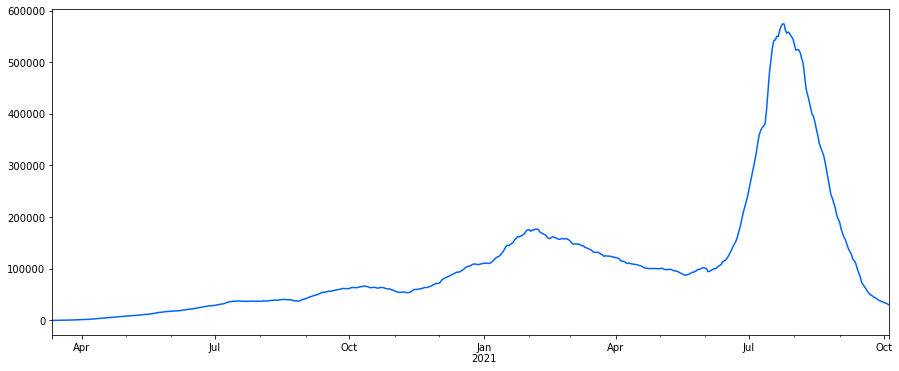

In [237]:
#Plot the sequence data 

df1['Kasus aktif'].plot(figsize=(15, 6))

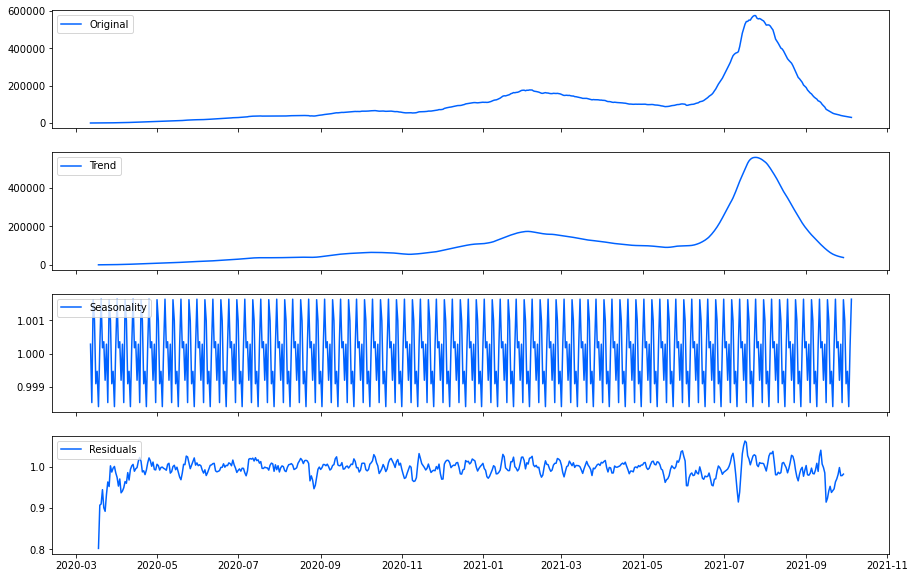

In [238]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df1, model='mul', period=12)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4,1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [239]:
# resample to annual and plot each
monthly_cases = df1.resample('M').mean()
#monthly_cases.plot(figsize=[14,4])
monthly_cases

,Kasus aktif
2020-03-31,514.500000
2020-04-30,4426.200000
2020-05-31,12435.516129
2020-06-30,22786.866667
2020-07-31,35358.129032
2020-08-31,38906.580645
2020-09-30,54175.833333
2020-10-31,63221.806452
2020-11-30,60277.233333
2020-12-31,95449.580645


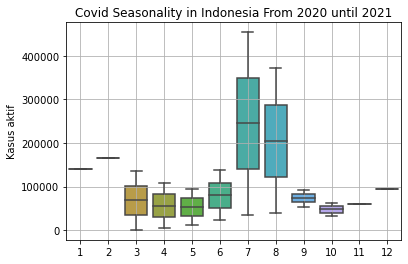

In [240]:
# boxplot of mean cases of months to determine variance and range
sns.boxplot(x=monthly_cases.index.month, y=monthly_cases['Kasus aktif'])
plt.title('Covid Seasonality in Indonesia From 2020 until 2021')
plt.grid(b=True); #GRID is to create rectangular block format


We can see  throughout years, July and August is the worst month

## Stationary or Not Stationary?

In [241]:
#Let's run the ADF test before transforming.
from statsmodels.tsa.stattools import adfuller, kpss
#Now we'll be doing statistical test for trend seasonality using KPSS.
#Null hypothesis for KPSS is opposite from ADF. If ADF null hypothesis is non-stationary, the KPSS null hypothesis is stationary. 


In [242]:

# ADF Test
result = adfuller(df1['Kasus aktif'].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
    
# KPSS Test
result = kpss(df1['Kasus aktif'].values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -3.189539330144429
p-value: 0.020598224784470924
Critial Values:
   1%, -3.4421447800270673
Critial Values:
   5%, -2.8667429272780858
Critial Values:
   10%, -2.5695409929766093

KPSS Statistic: 1.405611
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [243]:
# define Dickey-Fuller Test (DFT) function
# Null is that unit root is present, rejection means likely stationary
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries,)
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.grid()
    plt.show(block=False)

Test Statistic           -3.189539
p-value                   0.020598
Lags Used                15.000000
Observations Used       557.000000
Critical Value (1%)      -3.442145
Critical Value (5%)      -2.866743
Critical Value (10%)     -2.569541
dtype: float64


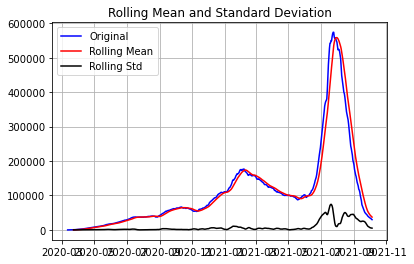

In [244]:
# run DFT on monthly
dftest(df1['Kasus aktif'])

# p-value fails to reject null hypothesis of non-stationary , thus data is non-stationary


Test Statistic           -3.458953
p-value                   0.009106
Lags Used                14.000000
Observations Used       557.000000
Critical Value (1%)      -3.442145
Critical Value (5%)      -2.866743
Critical Value (10%)     -2.569541
dtype: float64


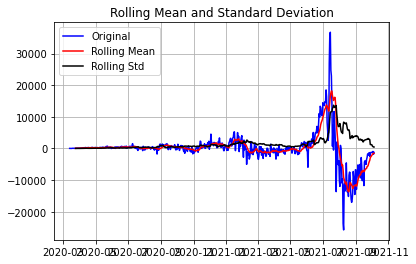

In [247]:
dftest(df1['Kasus aktif'].diff().dropna())

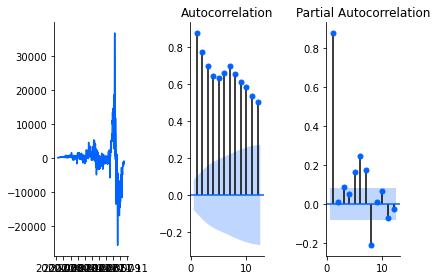

In [248]:
plots(df1['Kasus aktif'].diff(periods=1).dropna(), lags=12);
# open Duke guide for visual

From plot above, there are moving mean and moving variance, however from pvalue we can say this series is Non Stationary (weak seasonality)

## Stationary Transformation using Differencing

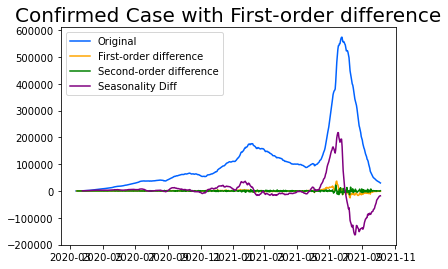

In [252]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#Try various differencing order
df1['Diff1'] = df1['Kasus aktif'].diff()
df1['Diff2'] = df1['Kasus aktif'].diff().diff()
df1['Seasonal_diff'] = df1['Kasus aktif'].diff(periods=12)

#case = case.dropna()

# Plot
plt.title('Confirmed Case with First-order difference', size=20)
plt.plot(df1['Kasus aktif'], label='Original')
plt.plot(df1['Diff1'], label='First-order difference', color='orange')

plt.plot(df1['Diff2'], label='Second-order difference', color='green')

plt.plot(df1['Seasonality_diff'], label='Seasonality Diff', color='purple')


plt.legend();

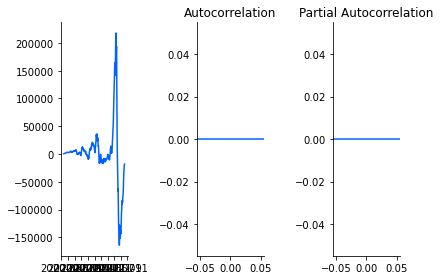

In [253]:
# helper plot for monthly temps
plots(df1['Seasonal_diff'], lags=12);
# open Duke guide for visual

In [279]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(df1['Kasus aktif'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                          seasonal=True,
                           d=0, D=0,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=10907.403, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=15053.010, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.46 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=14548.177, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=15398.095, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=10894.398, Time=1.18 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=10982.770, Time=0.42 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=10888.275, Time=2.96 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=10983.311, Time=4.44 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=14530.486, Time=0.93 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=11275.942, Time=1.20 sec
 ARIMA(2,0,1)(0,0,2)[12] intercept   : AIC=10588.974, Time=1.05 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=10588.331, Time=0.80 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=10592.352, Time=0.33 sec
 ARIMA(2,0,

In [280]:
sar = sm.tsa.statespace.SARIMAX(df1['Kasus aktif'], order=(2,0,0), seasonal_order=(0,0,1,12))
smodel_fit = sar.fit(disp=0)
print(smodel_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Kasus aktif   No. Observations:                  573
Model:             SARIMAX(2, 0, 0)x(0, 0, [1], 12)   Log Likelihood               -5289.591
Date:                              Sun, 10 Oct 2021   AIC                          10587.181
Time:                                      07:00:40   BIC                          10604.585
Sample:                                  03-12-2020   HQIC                         10593.970
                                       - 10-05-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8888      0.008    236.559      0.000       1.873       1.904
ar.L2         -0.88

In [298]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(df1['Kasus aktif'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                          seasonal=True,
                           d=1, D=0,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=10563.620, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=11403.288, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=10562.646, Time=0.44 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=10866.893, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=11401.347, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=10565.253, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=10563.531, Time=0.88 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=10562.723, Time=0.47 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=10562.156, Time=0.28 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=10563.104, Time=0.62 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=10564.707, Time=1.29 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=11236.234, Time=0.45 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=10563.512, Time=0.36 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=10563.406, Time=0.40 sec
 ARIM

In [263]:
sar = sm.tsa.statespace.SARIMAX(df1['Kasus aktif'], order=(1,1,0), seasonal_order=(0,0,1,12))
smodel_fit = sar.fit(disp=0)
print(smodel_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Kasus aktif   No. Observations:                  573
Model:             SARIMAX(1, 1, 0)x(0, 0, [1], 12)   Log Likelihood               -5277.079
Date:                              Sun, 10 Oct 2021   AIC                          10560.158
Time:                                      06:52:54   BIC                          10573.205
Sample:                                  03-12-2020   HQIC                         10565.248
                                       - 10-05-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8921      0.008    110.604      0.000       0.876       0.908
ma.S.L12      -0.10

In [281]:
#create dataframe that allow prediction 
from dateutil.relativedelta import relativedelta
def future_preds_df(model,series,num_months):
    pred_first = series.index.max()+relativedelta(months=0)
    pred_last = series.index.max()+relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first,pred_last,freq = 'MS')
    vals = model.predict(n_periods = num_months)
    return pd.DataFrame(vals,index = date_range_index)

In [282]:
preds = future_preds_df(stepwise_model,df1['Kasus aktif'],6)
preds.tail()

,0
2021-12-01,27872.591341
2022-01-01,26991.562691
2022-02-01,26323.112555
2022-03-01,25693.289163
2022-04-01,25016.326707


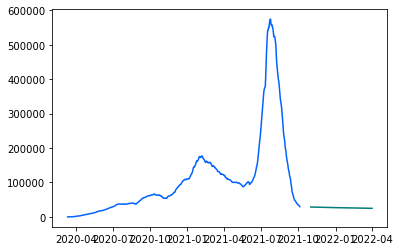

In [283]:
plt.plot(df1['Kasus aktif'])
plt.plot(preds)

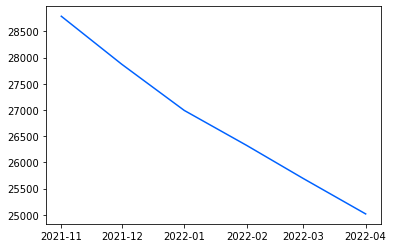

In [284]:
plt.plot(preds)

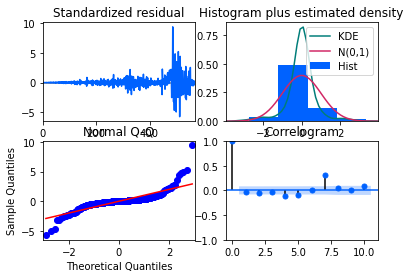

In [278]:
stepwise_model.plot_diagnostics();

In [285]:
def cross_validate(series,horizon,start,step_size,order = (1,0,0),seasonal_order = (0,0,0,0),trend=None):
    '''
    Function to determine in and out of sample testing of arima model    
    
    arguments
    ---------
    series (seris): time series input
    horizon (int): how far in advance forecast is needed
    start (int): starting location in series
    step_size (int): how often to recalculate forecast
    order (tuple): (p,d,q) order of the model
    seasonal_order (tuple): (P,D,Q,s) seasonal order of model
    
    Returns
    -------
    DataFrame: gives fcst and actuals with date of prediction
    '''
    fcst = []
    actual = []
    date = []
    for i in range(start,len(series)-horizon,step_size):
        model = sm.tsa.statespace.SARIMAX(series[:i+1], #only using data through to and including start 
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=trend).fit()
        fcst.append(model.forecast(steps = horizon)[-1]) #forecasting horisons in advance
        actual.append(series[i+horizon]) # comparing that to actual value at that point
        date.append(series.index[i+horizon]) # saving date of that value
    return pd.DataFrame({'fcst':fcst,'actual':actual},index=date)

#horisons: how far in advance we want to predict the series
#stepsize ; prediction every three months

In [288]:
warnings.filterwarnings("ignore")
series = df1['Kasus aktif']
horizon = 12
start = 400
step_size = 1
order = (1,1,0)
seasonal_order = (0,0,1,12)

cv1 = cross_validate(df1['Kasus aktif'],12,400,1,
                    order = order,
                    seasonal_order = seasonal_order)

In [289]:
model = sm.tsa.statespace.SARIMAX(series[:401], #only using data through start of 400
                                order=order, 
                                seasonal_order=seasonal_order, 
                                trend=None).fit()

In [290]:
#end of input
series[:401].tail()

2021-04-12    109372
2021-04-13    108599
2021-04-14    108384
2021-04-15    108032
2021-04-16    107297
Freq: D, Name: Kasus aktif, dtype: int64

In [291]:
#value to predict horizon steps into the future
series[412:413]

2021-04-28    100502
Freq: D, Name: Kasus aktif, dtype: int64

In [292]:
model.forecast(12)[-1:]

2021-04-28    105602.046099
Freq: D, Name: predicted_mean, dtype: float64

In [293]:
cv1.head()

,fcst,actual
2021-04-28,105602.046099,100502
2021-04-29,103979.677963,100102
2021-04-30,104074.064540,100213
2021-05-01,101038.291068,100250
2021-05-02,100478.046709,100760


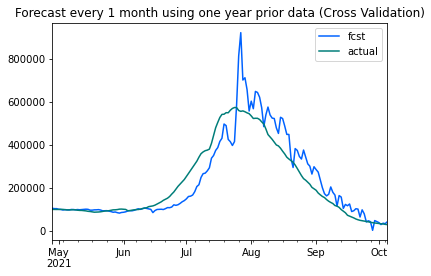

In [299]:
cv1.plot(title = 'Forecast every 1 month using one year prior data (Cross Validation)')

In [300]:
def mape(df_cv):
    return abs(df_cv.actual - df_cv.fcst).sum() / df_cv.actual.sum()

In [301]:
mape(cv1)

0.24364944439476058

In [302]:
corr = np.corrcoef(cv1['fcst'],cv1['actual'])[0,1]
corr

0.9147432670942446

In [225]:
sar = sm.tsa.statespace.SARIMAX(df1['Kasus aktif'], order=(2,2,3), seasonal_order=(0,0,1,12))
smodel_fit = sar.fit(disp=0)
print(smodel_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                          Kasus aktif   No. Observations:                  573
Model:             SARIMAX(2, 2, 3)x(0, 0, [1], 12)   Log Likelihood               -5248.770
Date:                              Sat, 09 Oct 2021   AIC                          10511.540
Time:                                      23:22:38   BIC                          10541.972
Sample:                                  03-12-2020   HQIC                         10523.413
                                       - 10-05-2021                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1671      0.040     29.308      0.000       1.089       1.245
ar.L2         -0.77